In [1]:
import pandas as pd
import numpy as np
print("Loading the training, test and store data")
types = {'CompetitionOpenSinceYear': np.dtype(int),'CompetitionOpenSinceMonth': np.dtype(int),'StateHoliday': np.dtype(str),'Promo2SinceWeek': np.dtype(int),'SchoolHoliday': np.dtype(float),'PromoInterval': np.dtype(str)}
train = pd.read_csv("inputs/train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("inputs/test.csv", parse_dates=[2], dtype=types)
store = pd.read_csv("inputs/store.csv")

Loading the training, test and store data


### Outliers-

In [2]:
Q1 = np.percentile(train['Sales'], 25)
Q3 = np.percentile(train['Sales'], 75)
step = step = 1.5 * (Q3 - Q1)
print "Data points considered outliers-"
#display(train[~((train['Sales'] >= Q1 - step) & (train['Sales'] <= Q3 + step))])
i=train[~((train['Sales'] >= Q1 - step) & (train['Sales'] <= Q3 + step))].index
print "Number of outliers in sales =", len(i)
Q1 = np.percentile(train['Customers'], 25)
Q3 = np.percentile(train['Customers'], 75)
step = step = 1.5 * (Q3 - Q1)
#display(train[~((train['Customers'] >= Q1 - step) & (train['Customers'] <= Q3 + step))])
j=train[~((train['Customers'] >= Q1 - step) & (train['Customers'] <= Q3 + step))].index
print "Number of outliers in customers =", len(j)
common_outliers = set(i).intersection(j)
print "Number of common outliers =", len(common_outliers)
print "Dropping common outliers..."
train = train.drop(train.index[list(common_outliers)]).reset_index(drop = True)
print float(len(common_outliers))*100/float(train.shape[0]), "%  of data dropped"

Data points considered outliers-
Number of outliers in sales = 15863
Number of outliers in customers = 22600
Number of common outliers = 11334
Dropping common outliers...
1.90838602133 %  of data dropped


### Preprocessing data

In [3]:
def preprocess(features, data):
    # remove NaNs-
    data.fillna(0, inplace=True)
    #take the store as open if no value given-
    data.loc[data.Open.isnull(), 'Open'] = 1
    #only process stores which are open, otherwise whats the point:
    data = data[data["Open"] != 0]         
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
  

    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    return features, data

In [4]:
import warnings
warnings.simplefilter(action = "ignore")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
features = []
features, train= preprocess(features, train)

#Drop rows where sales are zero
train = train[train["Sales"] > 0]

In [5]:
from sklearn import cross_validation

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test = cross_validation.train_test_split(train, test_size=0.25)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 368055 samples.
Testing set has 122686 samples.


In [6]:
from sklearn.metrics import mean_squared_error
from time import time
def train_regressor(rgr, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    
    # Start the clock, train the regressor, then stop the clock
    start = time()
    rgr.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(rgr, features, target):
    ''' Makes predictions using a fit regressor based on mean_squared_error '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = rgr.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    #return mean_squared_error(target.values, y_pred)
    return np.sqrt(((y_pred - target.values) ** 2).mean())



def train_predict(rgr, X_train, y_train, X_test, y_test):
    ''' Train and predict using a regressor based on F1 score. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(rgr.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(rgr, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "mean_squared_error for training set: {:.4f}.".format(predict_labels(rgr, X_train, y_train))
    print "mean_squared_error for test set: {:.4f}.".format(predict_labels(rgr, X_test, y_test))

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
rgr_A = DecisionTreeRegressor(random_state=0)
rgr_B = KNeighborsRegressor()
rgr_C = GradientBoostingRegressor()
i=np.log1p(X_train.Sales)
j=np.log1p(X_test.Sales)

In [8]:
train_predict(rgr_A, X_train[features], i, X_test[features], j)

Training a DecisionTreeRegressor using a training set size of 368055. . .
Trained model in 5.7585 seconds
Made predictions in 0.4843 seconds.
mean_squared_error for training set: 0.0000.
Made predictions in 0.1327 seconds.
mean_squared_error for test set: 0.1859.


In [9]:
train_predict(rgr_B, X_train[features], i, X_test[features], j)

Training a KNeighborsRegressor using a training set size of 368055. . .
Trained model in 2.8538 seconds
Made predictions in 21.9409 seconds.
mean_squared_error for training set: 0.1954.
Made predictions in 7.0320 seconds.
mean_squared_error for test set: 0.2475.


In [11]:
train_predict(rgr_C, X_train[features], i, X_test[features], j)

Training a GradientBoostingRegressor using a training set size of 368055. . .
Trained model in 60.6633 seconds
Made predictions in 0.9889 seconds.
mean_squared_error for training set: 0.3150.
Made predictions in 0.3285 seconds.
mean_squared_error for test set: 0.3159.


In [15]:
from sklearn.grid_search import GridSearchCV

i=i[X_train[features].index] #to avoid indexing error

param_grid = {"min_samples_split": [20, 15, 30],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [12, 8, 10]
              }
grid_search = GridSearchCV(rgr_A,param_grid=param_grid)
grid_search.fit(X_train[features],i)
x=predict_labels(grid_search, X_test[features], j)
print "The best parameters values are:", grid_search.best_params_
print "RMSE value after grid search =",x

Made predictions in 0.0641 seconds.
The best parameters values are: {'min_samples_split': 20, 'max_depth': None, 'min_samples_leaf': 8}
RMSE value after grid search = 0.163918324729


Feature ranking:
1. feature 1 :DayOfWeek (0.254320)
2. feature 0 :Store (0.206382)
3. feature 2 :Date (0.172261)
4. feature 13 :CompetitionOpenSinceYear (0.091545)
5. feature 8 :SchoolHoliday (0.071241)
6. feature 10 :Assortment (0.042359)
7. feature 5 :Open (0.035158)
8. feature 12 :CompetitionOpenSinceMonth (0.034278)
9. feature 14 :Promo2 (0.033655)
10. feature 6 :Promo (0.022376)
11. feature 3 :Sales (0.011258)
12. feature 9 :StoreType (0.011243)
13. feature 11 :CompetitionDistance (0.005961)
14. feature 4 :Customers (0.004231)
15. feature 15 :Promo2SinceWeek (0.002166)


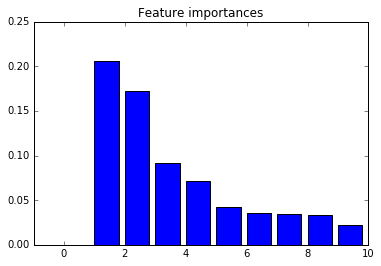

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
importances = rgr_A.feature_importances_ 
# return the indices that would sort the importance, decreasing
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(15):
    print("%d. feature %d :%s (%f)" % (f + 1, indices[f],X_train.columns[indices[f]], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(1,10), importances[indices[range(1,10)]]) 
plt.xlim([-1, 10])
plt.show()

In [14]:

p=[]
p, test= preprocess(p, test)
i=np.log1p(train.Sales)
i=i[train[features].index] #to avoid indexing error
rgr_A = DecisionTreeRegressor(min_samples_split= 20, max_depth= None, min_samples_leaf= 8)
rgr_A.fit(train[features], i)
#train over complete dataset and predict test-
pred =rgr_A.predict(test[features])
p_Sales =rgr_A.predict(test[features])
test['p_Sales'] = np.expm1(p_Sales)
test.to_csv("prediction.csv", index=False)